In [1]:
import sys

sys.path.insert(0, '/Users/egork/.pyenv/versions/3.6.7/lib/python3.6/site-packages/')
%matplotlib inline

from scipy.io import loadmat
import pandas as pd

import matplotlib.pyplot as plt
import seaborn
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
import time
from sklearn.preprocessing import minmax_scale
from random import sample
from random import seed
from sklearn.preprocessing import minmax_scale, LabelEncoder
from sklearn.utils.multiclass import type_of_target
epsilon = 10**(-8)

In [2]:
import glob
data_files = glob.glob('./data/*.mat')
print(data_files)

['./data/pima.mat', './data/arrhythmia.mat', './data/shuttle.mat', './data/thyroid.mat', './data/breastw.mat', './data/satellite.mat', './data/annthyroid.mat', './data/ionosphere.mat', './data/smtp.mat', './data/mammography.mat']


In [3]:
def read_data(file_name):
    print(file_name)
    data = loadmat(file_name)

    return data['X'], data['y']

In [4]:
file_name = './data/pima.mat'
x={}
features, label = read_data(file_name)

./data/pima.mat


In [5]:
features.shape[0]*0.04

30.72

In [6]:
min_leaf_size, n_trees = 30, 500

In [7]:
forest_parameters = dict(n_estimators=n_trees, criterion='mae', max_features=0.333333,
                         oob_score=True, verbose=1, n_jobs=-1,  min_samples_leaf=min_leaf_size)

In [8]:
features.shape

(768, 8)

In [10]:
print(pd.DataFrame(features).nunique().values)
print(pd.DataFrame(features).nunique().values/features.shape[0])

[ 17 136  47  51 186 248 517  52]
[0.02213542 0.17708333 0.06119792 0.06640625 0.2421875  0.32291667
 0.67317708 0.06770833]


In [11]:
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.metrics import explained_variance_score

In [9]:
from sklearn.ensemble._forest import _generate_unsampled_indices
from sklearn.metrics import explained_variance_score

def _set_oob_error(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]
        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx])
    return np.array([np.sum(((values - y[idx])**2)/len(values)) for idx, values in enumerate(predictions)])


def _set_oob_variance(estimators_, X, y):
    """
    Compute out-of-bag variance."""

    n_samples = y.shape[0]

    predictions = [[] for _ in range(n_samples)]
    n_predictions = np.zeros((n_samples, 1))

    n_samples_bootstrap = n_samples

    for estimator in estimators_:
        unsampled_indices = _generate_unsampled_indices(
            estimator.random_state, n_samples, n_samples_bootstrap)
        p_estimator = estimator.predict(
            X[unsampled_indices, :], check_input=False)


        p_estimator = p_estimator[:, np.newaxis]

        for idx, value in enumerate(unsampled_indices):
            predictions[value].append(p_estimator[idx].tolist()[0])
    return np.array([np.var(arr) for arr in predictions])


def compute_metric_single_feature(features, feature_index):
    print("Continious appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()

    regressor=RandomForestRegressor(**forest_parameters)
    
    
    y=features[:, feature_index]    
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    regressor.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))


    predictions = regressor.oob_prediction_
    
    results_pd['prediction_{}'.format(feature_index)] = pd.Series(np.array(predictions)[:])
    np_log=np.log(np.abs((np.array(predictions)[:]+epsilon)/(y+epsilon)))
    abs_diff = np.abs(np.array(predictions)[:] - y) + epsilon
    results_pd['abs_diff_{}'.format(feature_index)] = pd.Series(abs_diff)
    results_pd['abs_diff_min_max_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(abs_diff, feature_range=(epsilon, 1)))

    results_pd['abs_diff_median_scaling_{}'.format(feature_index)] = pd.Series(minmax_scale(_set_oob_error(regressor.estimators_, np.array(train, dtype=np.float32), y)))
    results_pd['log_ratio_{}'.format(feature_index)] = pd.Series(np_log)
    results_pd['log_abs_ratio_{}'.format(feature_index)] = pd.Series(np.abs(np_log))
    feature_imp = np.insert(regressor.feature_importances_, feature_index, 0,axis=0)
    weight = 1 - min(1, (1 - metrics.r2_score(y, np.array(predictions)[:],
                                              multioutput='raw_values'))**0.5)
    print("Weight: {}".format(weight))
    results_pd['weighted_abs_diff_median_scaling_{}'.format(feature_index)] =  weight * pd.Series(abs_diff/(np.median(abs_diff)+epsilon))
    return results_pd

def compute_metrics_single_categorical_feature(features, feature_index, bin_number=None):
    print("Categorical appraoch feature {}".format(feature_index))
    results_pd = pd.DataFrame()
    classifier = RandomForestClassifier(oob_score=True, 
                                        n_estimators=n_trees, bootstrap=True, n_jobs=-1,
                                        criterion='entropy', min_samples_leaf=min_leaf_size, verbose=1)

    y=features[:, feature_index]
    if bin_number or type_of_target(features[:, feature_index])=='continuous':
        if bin_number:
            bins = min(np.unique(y).shape[0], bin_number)
        else:
            bins = np.unique(y).shape[0]
        y = np.digitize(y, bins=np.histogram(y, bins=bins)[1])
    train=np.delete(features, [feature_index], axis=1)
    start_time = time.time()
    
    classifier.fit(X=train, y=y)
    print("--- %s seconds fit ---" % (time.time() - start_time))

    y_map={value: list(set(y.flatten())).index(value)  for value in set(y.flatten())}

    probability_scores=[classifier.oob_decision_function_[index,:][y_map[element]] for index, element in enumerate(y.flatten())]
    
    entropy_list=[]
    num_classes=np.unique(y).shape[0]
    if num_classes>1:
        max_entropy = np.log(num_classes)
    else:
        max_entropy = 1
    #__import__('pdb').set_trace()
    entropy_np = np.array([sum([-value*np.log(value+epsilon) for value in ls])/max_entropy + (1.0-probability_scores[idx]) for idx, ls in enumerate(classifier.oob_decision_function_)])
    results_pd["abs_diff_median_scaling_{}".format(feature_index)] = minmax_scale(pd.Series(entropy_np))
    return results_pd

In [11]:
## Average forest

results_all_features_pd = pd.DataFrame()
feature_weights=np.zeros(features.shape[1])
feature_weights_r2=[]
min_number_of_values = 100
num_feature_index = [feature_index for feature_index in range(features.shape[1])
                     if len(set(features[:, feature_index])) > 0]
bin_number = None
for feature_index in num_feature_index:
    print('--- feature index {} / {} ---'.format(feature_index, features.shape[1]-1))
    if len(set(features[:, feature_index])) > min_number_of_values:
        results_pd = compute_metric_single_feature(features, feature_index)
    else:
        results_pd = compute_metrics_single_categorical_feature(features, feature_index, bin_number)
 
    results_all_features_pd[results_pd.columns] = results_pd


--- feature index 0 / 7 ---
Categorical appraoch feature 0


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.8s finished


--- 1.4180922508239746 seconds fit ---
--- feature index 1 / 7 ---
Continious appraoch feature 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.5s finished


--- 2.049041271209717 seconds fit ---
Weight: [0.11527608]
--- feature index 2 / 7 ---
Categorical appraoch feature 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4238629341125488 seconds fit ---
--- feature index 3 / 7 ---
Categorical appraoch feature 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.0s finished


--- 1.5319271087646484 seconds fit ---
--- feature index 4 / 7 ---
Continious appraoch feature 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.2s finished


--- 1.6923301219940186 seconds fit ---
Weight: [0.08613389]
--- feature index 5 / 7 ---
Continious appraoch feature 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


--- 1.9108688831329346 seconds fit ---
Weight: [0.15092985]
--- feature index 6 / 7 ---
Continious appraoch feature 6


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    1.4s finished


--- 1.8801119327545166 seconds fit ---
Weight: 0
--- feature index 7 / 7 ---
Categorical appraoch feature 7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished


--- 1.4241111278533936 seconds fit ---


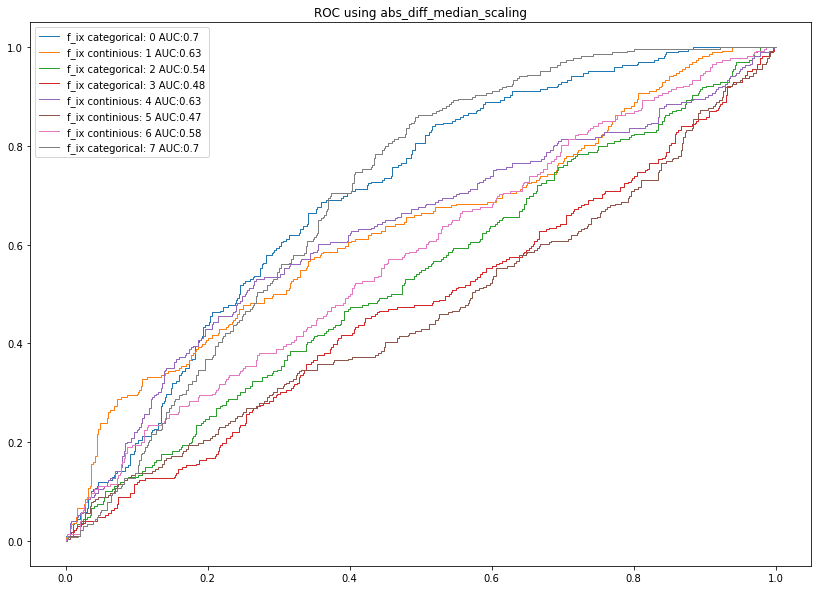

0.7019477611940298


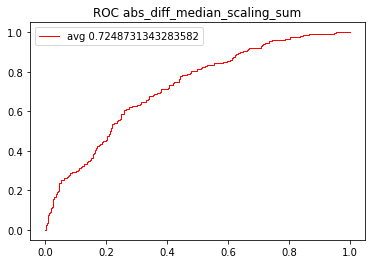

In [12]:
metric_name = 'abs_diff_median_scaling'
plt.figure(figsize=[14, 10])
auc=[]
columns_list_names=['{}_{}'.format(metric_name, feature_index) for feature_index in num_feature_index]

for feature_index in num_feature_index:
    fpr, tpr, thresholds = metrics.roc_curve(label.flatten(),
                                             results_all_features_pd['{}_{}'.format(metric_name, feature_index )],
                                             pos_label=1)
    if len(set(features[:, feature_index])) > min_number_of_values:
        message = "f_ix continious: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    else:
        message = "f_ix categorical: {} AUC:{:.2}".format(feature_index, metrics.auc(fpr, tpr))
    plt.plot(fpr, tpr, lw=1, label=message,
             color='C{}'.format(feature_index%10))
    plt.title("ROC using {}".format(metric_name))
    auc.append(metrics.auc(fpr, tpr))
plt.legend()
plt.show()
print(max(auc))

# simple sum
metric_sum =(results_all_features_pd[columns_list_names]).sum(axis=1)
fpr1, tpr1, thresholds1 = metrics.roc_curve(label.flatten(), metric_sum, pos_label=1)
plt.plot(fpr1, tpr1, color='red', lw=1, label='avg {}'.format(metrics.auc(fpr1, tpr1)))
plt.title("ROC {}_sum".format(metric_name))
plt.legend()
plt.show()